# RBM
https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/rbm_deep_dive.ipynb

## Prepare

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill 

#RBM 
from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix

#Evaluation libraries
from recommenders.datasets import movielens 

from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)

from recommenders.tuning.parameter_sweep import generate_param_grid
#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0]
Pandas version: 1.1.5


In [2]:
import fun
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType, StructType, StructField
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation, SparkDiversityEvaluation

## Setup Data

In [3]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [4]:
mldf_100k_full = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp'],
    title_col='title',
    genres_col='genres'
)

data_full_spark = fun.movielens_to_spark(mldf_100k_full, schema = fun.get_movielens_schema())

# Convert the float precision to 32-bit in order to reduce memory consumption 
mldf_100k_full.loc[:, 'rating'] = mldf_100k_full['rating'].astype(np.int32) 

mldf_100k_full.head()

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.62kKB/s]


Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+------+-------+------+---------+------------+------+
|UserId|MovieId|Rating|Timestamp|       title|genres|
+------+-------+------+---------+------------+------+
|   196|    242|   3.0|881250949|Kolya (1996)|Comedy|
|    63|    242|   3.0|875747190|Kolya (1996)|Comedy|
|   226|    242|   5.0|883888671|Kolya (1996)|Comedy|
|   154|    242|   3.0|879138235|Kolya (1996)|Comedy|
|   306|    242|   5.0|876503793|Kolya (1996)|Comedy|
+------+-------+------+---------+------------+------+
only showing top 5 rows



,userID,movieID,rating,timestamp,title,genres
0,196,242,3,881250949,Kolya (1996),Comedy
1,63,242,3,875747190,Kolya (1996),Comedy
2,226,242,5,883888671,Kolya (1996),Comedy
3,154,242,3,879138235,Kolya (1996),Comedy
4,306,242,5,876503793,Kolya (1996),Comedy


In [5]:
mldf_100k = mldf_100k_full[['userID','movieID','rating','timestamp']]
mldf_100k.head()

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,63,242,3,875747190
2,226,242,5,883888671
3,154,242,3,879138235
4,306,242,5,876503793


In [6]:
feature_data = fun.create_feature_data(data_full_spark)

In [7]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

#100k
am100k = AffinityMatrix(df = mldf_100k, **header)

X100k, users100k, items100k = am100k.gen_affinity_matrix()
#print(type(X100k))
Xtr_100k, Xtst_100k = numpy_stratified_split(X100k)
#print(type(Xtr_100k))

In [8]:
train_pandas = am100k.map_back_sparse(Xtr_100k, kind = 'ratings')
train_pandas.head()

,userID,movieID,rating
0,1,12,5
1,1,254,1
2,1,189,3
3,1,87,5
4,1,187,4


In [9]:
traintestschema = StructType(
    (StructField("UserId", IntegerType()),
    StructField("MovieId", IntegerType()),
    StructField("Rating", FloatType())))

In [10]:
train_pandas['rating'] = train_pandas['rating'].astype(float)
train_df_spark = fun.movielens_to_spark(train_pandas, schema = traintestschema)

Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)

+------+-------+------+
|UserId|MovieId|Rating|
+------+-------+------+
|     1|     12|   5.0|
|     1|    254|   1.0|
|     1|    189|   3.0|
|     1|     87|   5.0|
|     1|    187|   4.0|
+------+-------+------+
only showing top 5 rows



## Train and predict rbm like in notebook

In [11]:
#100k
model_100k = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60,keep_prob= 0.9, with_metrics = True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU d

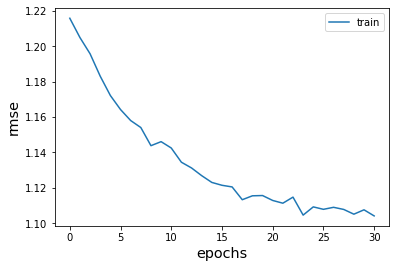

In [12]:
train_time = model_100k.fit(Xtr_100k, Xtst_100k)

In [13]:
#Model prediction on the test set Xtst. 
top_k_100k, test_time =  model_100k.recommend_k_items(Xtst_100k, top_k = TOP_K)

#to df
top_k_df_100k = am100k.map_back_sparse(top_k_100k, kind = 'prediction')
test_df_100k = am100k.map_back_sparse(Xtst_100k, kind = 'ratings')
top_k_df_100k.head()

,userID,movieID,prediction
0,1,114,4.819293
1,1,134,4.846283
2,1,1,4.744581
3,1,228,4.578108
4,1,178,4.632440


## Make topk reco with examples

In [14]:
top_k_with_info = (top_k_df_100k.join(mldf_100k_full[['movieID', 'title', 'genres']].drop_duplicates().set_index('movieID'), 
                                on='movieID', 
                                how='inner').sort_values(by=['userID', 'prediction'], ascending=False))
display(top_k_with_info.head(30))

,userID,movieID,prediction,title,genres
9420,943,195,4.871876,"Terminator, The (1984)",Action|Sci-Fi|Thriller
9422,943,405,4.845734,Mission: Impossible (1996),Action|Adventure|Mystery
9423,943,808,4.716200,"Program, The (1993)",Action|Drama
9425,943,1104,4.714013,C'est arrivé près de chez vous (1992),Comedy|Crime|Drama
9421,943,216,4.709321,When Harry Met Sally... (1989),Comedy|Romance
9427,943,1463,4.708758,"Boys, Les (1997)",Comedy
9428,943,1581,4.695718,"Woman in Question, The (1950)",Mystery
9424,943,1044,4.606189,"Paper, The (1994)",Comedy|Drama
9429,943,1638,4.595568,Normal Life (1996),Crime|Drama
9426,943,1424,4.591640,I Like It Like That (1994),Comedy|Drama|Romance


In [15]:
top_k_with_info.to_csv("rbm_topk_visual_results.csv", index = False)

## Evaluate

### Use recommenders example approach for precision and recall

In [26]:
#collection of evaluation metrics for later use
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [40]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df_100k,
    data_pred =top_k_df_100k,
    time_train=train_time,
    time_test =test_time,
    K=20) 

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,Train time (s),Test time (s)
0,mv 100k,20,0.162418,0.389492,0.25684,0.296584,2.984583,0.209163


### Use our methods for diversity metrics,leave ratings as NA

In [29]:
topk_spark = fun.movielens_to_spark(top_k_df_100k, schema = fun.get_predictions_schema())

Spark df created, info: 

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- prediction: float (nullable = true)

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|     50| 4.8622932|
|     1|    114| 4.6985645|
|     1|     32|  4.717861|
|     1|    134|  4.829855|
|     1|     33| 4.7297573|
+------+-------+----------+
only showing top 5 rows



In [30]:
def get_diversity_results(diversity_eval):
    metrics = {
        "catalog_coverage":diversity_eval.catalog_coverage(),
        "distributional_coverage":diversity_eval.distributional_coverage(), 
        "novelty": diversity_eval.novelty(), 
        "diversity": diversity_eval.diversity(), 
        "serendipity": diversity_eval.serendipity()
    }
    return metrics

Collaborative

In [31]:
collaborative_diversity_eval = SparkDiversityEvaluation(
        train_df = train_df_spark, 
        reco_df = topk_spark,
        col_user = "UserId", 
        col_item = "MovieId"
    )
diversity_collaborative = get_diversity_results(collaborative_diversity_eval)

In [32]:
print("Collaborative diversity:\t%f" % diversity_collaborative['diversity'],
      "Collaborative serendipity:\t%f" % diversity_collaborative['serendipity'], 
     "Collaborative novelty:\t%f" % diversity_collaborative['novelty'], sep='\n')

Collaborative diversity:	0.958215
Collaborative serendipity:	0.920970
Collaborative novelty:	11.310526


Content

In [33]:
content_diversity_eval = SparkDiversityEvaluation(
        train_df = train_df_spark, 
        reco_df = topk_spark,
        item_feature_df = feature_data, 
        item_sim_measure="item_feature_vector",
        col_user = "UserId", 
        col_item = "MovieId"
    )
diversity_content = get_diversity_results(content_diversity_eval)

In [34]:
print("Content diversity:\t%f" % diversity_content['diversity'],
      "Content serendipity:\t%f" % diversity_content['serendipity'], 
     "Content novelty:\t%f" % diversity_content['novelty'], sep='\n')

Content diversity:	0.879836
Content serendipity:	0.885715
Content novelty:	11.310526
